In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics as stat
import numpy as np

In [2]:
mendota = pd.read_csv('mendota.csv')
monona = pd.read_csv('monona.csv')

In [3]:
years = list(range(1855,2019))

mendota_y = mendota.days
monona_y = monona.days

In [4]:
mendota = pd.DataFrame({'years':years,'days':mendota_y})
monona = pd.DataFrame({'years':years,'days':monona_y})

# Question1

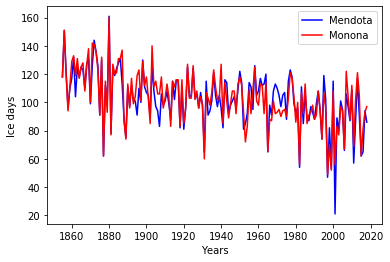

In [5]:
# plt.figure(dpi = 300)
plt.plot(years,mendota_y, color = 'blue',label = 'Mendota')
plt.plot(years,monona_y, color = 'red', label = 'Monona')
plt.ylabel('Ice days')
plt.xlabel('Years')
plt.legend()
# plt.savefig('q1_1.pdf')

In [6]:
diff_y = [monona_y[i] - mendota_y[i] for i in range(len(monona_y))]

Text(0.5, 0, 'Years')

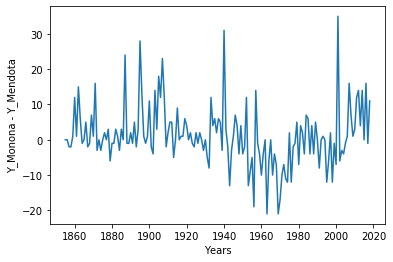

In [7]:
# plt.figure(dpi = 300)
plt.plot(years,diff_y)
plt.ylabel('Y_Monona - Y_Mendota')
plt.xlabel('Years')
# plt.savefig('q1_2.pdf')

# Question 2

In [47]:
year2ind = 1855  # convert year value to index value
train_ind = list(range(1855-year2ind,1971-year2ind))
test_ind = list(range(1971-year2ind,2019-year2ind))

In [48]:
# train/test split
men_train = mendota.iloc[train_ind]
men_test = mendota.iloc[test_ind]
mo_train = monona.iloc[train_ind]
mo_test = monona.iloc[test_ind]

In [10]:
men_mean = men_train.days.mean()
men_std = men_train.days.std()
mo_mean = mo_train.days.mean()
mo_std = mo_train.days.std()

print("Mendota:")
print("  mean: ", men_mean)
print("  std: ",men_std)
print("Monona:")
print("  mean: ", mo_mean)
print("  std: ",mo_std)

Mendota:
  mean:  107.1896551724138
  std:  16.74666159754441
Monona:
  mean:  108.48275862068965
  std:  18.122521543826256


In [11]:
def get_stdev(data):
    '''
    input: list
    '''
    mu = stat.mean(data)
    sum = 0
    for i in range(len(data)):
        sum += (data[i] - mu)**2
    sum = sum/(len(data)-1)   
    return math.sqrt(sum)

In [12]:
print(get_stdev(mo_train.days.to_list()))
print(mo_train.days.std())

18.122521543826252
18.122521543826256


# Question 3 (Use MLE to find best parameters)

In [13]:
men_train2 = pd.DataFrame({'x0':[1]*len(men_train),'x1':men_train.years,'x2':mo_train.days,'y':men_train.days})
men_test2 = pd.DataFrame({'x0':[1]*len(men_test),'x1':men_test.years,'x2':mo_test.days,'y':men_test.days})

In [14]:
# get numpy array form of X and Y for mendota training set
men_train_X = (men_train2.drop(columns = 'y')).as_matrix()
# men_train_X_T = men_train_X.T
men_train_Y = men_train2.y.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [331]:
# estimate parameter using MLE solution: (X^t*Z)^(-1)*X^t*Y
men_param = np.matmul(men_train_X.T,men_train_X)
men_param = np.linalg.inv(men_param)
men_param = np.matmul(men_param, men_train_X.T)
men_param = np.matmul(men_param, men_train_Y)
print('%f,' % men_param[0], '%f,' % men_param[1], '%f' % men_param[2])

-64.182766, 0.041225, 0.852951


# Question 4

In [332]:
# predict test set
pred = []
for i in range(len(men_test)):
    pred.append(men_param[0]*men_test2.iloc[i].x0 + men_param[1]*men_test2.iloc[i].x1 + men_param[2]*men_test2.iloc[i].x2)
    

In [333]:
# calculate MSE
MSE = 0
for i in range(len(pred)):
    MSE += (pred[i] - men_test2.iloc[i].y)**2
MSE = MSE/len(pred)
MSE

124.26409483979052

In [334]:
# calculate R^2
numerator = 0
denominator = 0
for i in range(len(pred)):
    numerator += (pred[i] - men_test2.iloc[i].y)**2
    denominator += (men_test2.iloc[i].y - men_test2.y.mean())**2

R2 = 1 - numerator/denominator

R2

0.7104900715614509

# Question 5 & 6

In [20]:
def get_MSE(pred, true):
    MSE = 0
    for i in range(len(pred)):
#         print(str(i)+": ", pred[i] - true[i])
        MSE += (pred[i] - true[i])**2
    MSE = MSE/len(pred)
    return MSE

In [16]:
def get_R2(pred, true):
    numerator = 0
    denominator = 0
    for i in range(len(pred)):
        numerator += (pred[i] - true[i])**2
        denominator += (true[i]- stat.mean(true))**2
    R2 = 1 - numerator/denominator
    return R2

In [17]:
def get_gradient(X,Y,param):
    '''
    x: d-dimension vector
    y: single real value
    '''
    gradient = [0,0,0]
    for i in range(len(X)):
        for j in range(3):
            col = 'x'+str(j)
            gradient[j] += (X.iloc[i].x0*param[0]+X.iloc[i].x1*param[1]+X.iloc[i].x2*param[2]-Y[i])*X.iloc[i][col]
    gradient = [gradient[i]*2/len(Y) for i in range(3)]
    return gradient

In [21]:
def train(dataset, epoch, init_param, lr):
    param = init_param
    for e in range(epoch):
        pred = []
        for i in range(len(dataset)):
            p = dataset.iloc[i].x0*param[0]+dataset.iloc[i].x1*param[1]+dataset.iloc[i].x2*param[2]
            pred.append(p)
        loss = get_MSE(pred,dataset.y.to_list())
#         loss = get_R2(pred,dataset.y.to_list())
        print("epoch " + str(e)+": ",loss)
#         print("epoch " + str(e)+": ")
#         print("  loss = " + str(loss))
#         print('  param: %f,' % param[0], '%f,' % param[1], '%f' % param[2])
        gradient = get_gradient(dataset.drop(columns = {'y'}),dataset.y,param)
        param = [param[d] - lr*gradient[d] for d in range(3)]
#         print(param)

In [22]:
train(men_train2, epoch=10,init_param=[0,0,0],lr =0.1)

epoch 0:  11767.655172413793
epoch 1:  6180350808297761.0
epoch 2:  3.330626781514358e+27
epoch 3:  1.7948940285065868e+39
epoch 4:  9.672787691041719e+50
epoch 5:  5.212721209720432e+62
epoch 6:  2.8091655971560845e+74
epoch 7:  1.5138755814390704e+86
epoch 8:  8.158363032772628e+97
epoch 9:  4.396589005764993e+109


In [23]:
# lr_ = 0.1
# for i in range(10):
#     lr_ = lr_/10
#     print("lr = ", lr_)
#     print("============================")
#     train(men_train2, epoch=10,init_param=[0,0,0],lr = lr_)

# Question 7

In [44]:
X_12 = men_train2.drop(columns = ['x0','y'])
norm_X12 = (X_12-X_12.mean())/X_12.std()

norm_men_train = pd.DataFrame()
norm_men_train['x0'] = men_train2.x0
norm_men_train['x1'] = norm_X12.x1
norm_men_train['x2'] = norm_X12.x2
norm_men_train['y'] = men_train2.y

In [45]:
train(norm_men_train, epoch=10,init_param=[0,0,0],lr =0.1)

epoch 0:  11767.655172413793
epoch 1:  7545.998373501812
epoch 2:  4850.273518530398
epoch 3:  3127.473895121937
epoch 4:  2025.60791967957
epoch 5:  1320.3620154290256
epoch 6:  868.6443341670556
epoch 7:  579.0974806545669
epoch 8:  393.3511885316234
epoch 9:  274.0870881867737


# Question 8

In [51]:
# get numpy array form of X and Y for mendota training set
men_train_X = (men_train2.drop(columns = ['y','x2'])).as_matrix()
# men_train_X_T = men_train_X.T
men_train_Y = men_train2.y.as_matrix()

# estimate parameter using MLE solution: (X^t*Z)^(-1)*X^t*Y
men_param = np.matmul(men_train_X.T,men_train_X)
men_param = np.linalg.inv(men_param)
men_param = np.matmul(men_param, men_train_X.T)
men_param = np.matmul(men_param, men_train_Y)
print('%f,' % men_param[0], '%f,' % men_param[1])

406.111060, -0.156299,


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [53]:
#Weka 
men_weka_train = pd.DataFrame({'1':[1]*len(men_train),'years':men_train.years,'Monona':mo_train.days,'days':men_train.days})

In [54]:
men_weka_train.to_csv('men_weka.csv')